# Installs & Imports

In [1]:
!pip install -q lightgbm xgboost ydf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin

import xgboost as xgb
import lightgbm as lgb

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

import ydf

# Data Loading

In [3]:
# Load the Diabetes dataset
diabetes = load_diabetes(as_frame=True)
df = diabetes.frame
display(df.head(10))

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041176,-0.096346,97.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062917,-0.038357,138.0
7,0.063504,0.050680,-0.001895,0.066629,0.090620,0.108914,0.022869,0.017703,-0.035816,0.003064,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014960,0.011349,110.0
9,-0.070900,-0.044642,0.039062,-0.033213,-0.012577,-0.034508,-0.024993,-0.002592,0.067737,-0.013504,310.0


# Data Preparation

In [4]:
# Define features and target
X = df.drop(columns=['target'])
y = df['target']

# Print shapes
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (442, 10)
y shape: (442,)


In [5]:
# Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Print shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (353, 10)
y_train shape: (353,)
X_test shape: (89, 10)
y_test shape: (89,)


# Model Training

In [6]:
# Define helper metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    eps = 1e-6
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## RL-GBM

In [7]:
class RLGBMRegressor(BaseEstimator, RegressorMixin):
    """
    RL-enhanced GBM Regressor with:
      - A configurable action space via an input dictionary.
      - Rich state representation (including temporal context and an overfitting signal).
      - Double Q-Learning with a target network.
      - Delayed rewards using an n-step buffer.
      - Detailed logging and early stopping.

    The action space can be specified as a dictionary with keys for hyperparameters.
    For example:

      action_space = {
          "lr_multipliers": [0.8, 1.0, 1.2],
          "tree_depths": [3, 4, 5],
          "min_samples_splits": [2, 5]
      }

    If not provided, a default action space is used.
    """
    def __init__(
        self,
        base_learn_rate=0.1,
        M=200,
        epsilon=0.1,
        n_step=3,
        replay_buffer_size=1000,
        batch_size=32,
        target_update_freq=50,
        gamma_rl=0.9,
        dqn_lr=0.001,
        validation_fraction=0.1,
        early_stopping_patience=20,
        reg_lambda=0.1,
        action_space=None,
        random_state=None,
        verbose=0
    ):
        # Boosting parameters
        self.base_learn_rate = base_learn_rate
        self.M = M
        self.validation_fraction = validation_fraction
        self.early_stopping_patience = early_stopping_patience
        self.reg_lambda = reg_lambda  # Strength of overfitting penalty
        self.random_state = random_state
        self.verbose = verbose

        # RL / DQN parameters
        self.epsilon = epsilon
        self.n_step = n_step
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.gamma_rl = gamma_rl
        self.dqn_lr = dqn_lr

        # Configurable action space
        if action_space is None:
            action_space = {
                "lr_multipliers": [0.8, 1.0, 1.2],
                "tree_depths": [3, 4, 5],
                "min_samples_splits": [2, 5]
            }
        self.action_space = action_space
        # Compute the Cartesian product of hyperparameter options
        self.actions = list(product(
            action_space["lr_multipliers"],
            action_space["tree_depths"],
            action_space["min_samples_splits"]
        ))
        self.num_actions = len(self.actions)

        # Define state dimension
        # State vector: [avg_abs_gradient, std_gradient, normalized_iteration, train_val_gap, last_reward]
        self.state_dim = 5

        # Initialize experience replay and n-step buffers
        self.replay_buffer = []
        self.n_step_buffer = []

        # Build the DQN and the target network
        self.dqn_model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_network()

    def _build_model(self):
        """Build and compile the DQN network."""
        model = models.Sequential()
        model.add(layers.Input(shape=(self.state_dim,)))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.num_actions, activation='linear'))
        model.compile(optimizer=optimizers.Adam(learning_rate=self.dqn_lr), loss='mse')
        return model

    def update_target_network(self):
        """Updates the target network with the weights from the DQN."""
        self.target_model.set_weights(self.dqn_model.get_weights())

    def store_transition(self, transition):
        """Store a transition tuple (s, a, R, s_next, done) in the replay buffer."""
        self.replay_buffer.append(transition)
        if len(self.replay_buffer) > self.replay_buffer_size:
            self.replay_buffer.pop(0)

    def train_dqn(self):
        """Train the DQN using a minibatch from the replay buffer with Double Q-Learning."""
        if len(self.replay_buffer) < self.batch_size:
            return
        indices = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
        minibatch = [self.replay_buffer[i] for i in indices]

        states = np.vstack([transition[0] for transition in minibatch])
        actions = np.array([transition[1] for transition in minibatch], dtype=int)
        rewards = np.array([transition[2] for transition in minibatch], dtype=float)
        next_states = np.vstack([transition[3] for transition in minibatch])
        dones = np.array([transition[4] for transition in minibatch], dtype=bool)

        # Double DQN update
        q_values = self.dqn_model.predict(states, verbose=0)
        q_next_main = self.dqn_model.predict(next_states, verbose=0)
        q_next_target = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                best_next_action = np.argmax(q_next_main[i])
                q_values[i, actions[i]] = rewards[i] + self.gamma_rl * q_next_target[i, best_next_action]

        self.dqn_model.fit(states, q_values, epochs=1, verbose=0)

    def _get_state(self, g, t, train_loss, val_loss, last_reward):
        """
        Compute the state vector given:
          - g: the residual (gradient)
          - t: current iteration
          - train_loss, val_loss: current losses (MAPE) on training and validation sets
          - last_reward: last observed reward
        """
        eps = 1e-6
        avg_g = np.mean(np.abs(g))
        std_g = np.std(g)
        norm_iter = t / self.M
        train_val_gap = val_loss - train_loss  # Overfitting indicator
        state = np.array([avg_g, std_g, norm_iter, train_val_gap, last_reward]).reshape(1, -1)
        return state

    def select_action(self, state):
        """Select an action using an epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            action_idx = np.random.randint(self.num_actions)
        else:
            q_vals = self.dqn_model.predict(state, verbose=0)
            action_idx = np.argmax(q_vals[0])
        return action_idx, self.actions[action_idx]

    def log_progress(
        self,
        t,
        state,
        chosen_action,
        train_loss,
        val_loss,
        immediate_reward,
        reg_penalty,
        adjusted_reward
    ):
        """Logs detailed progress information if verbose is enabled."""
        if self.verbose:
            print(
                f"Iter {t}/{self.M} | State: {state.flatten()} | Action: {chosen_action} | "
                f"Train MAPE: {train_loss:.4f} | Val MAPE: {val_loss:.4f} | "
                f"Immediate Reward: {immediate_reward:.4f} | Reg Penalty: {reg_penalty:.4f} | "
                f"Adjusted Reward: {adjusted_reward:.4f}"
            )

    def flush_n_step_buffer(self):
        """Flush remaining transitions from the n-step buffer into the replay buffer."""
        while self.n_step_buffer:
            cum_reward = 0
            for i in range(len(self.n_step_buffer)):
                cum_reward += (self.gamma_rl ** i) * self.n_step_buffer[i][2]
            s0, a0, _, _, _ = self.n_step_buffer[0]
            s_next = self.n_step_buffer[-1][3]
            self.store_transition((s0, a0, cum_reward, s_next, True))
            self.n_step_buffer.pop(0)

    def fit(self, X, y, eval_set=None):
        # If no external validation set is provided, split from training data
        if eval_set is None:
            X, X_val, y, y_val = train_test_split(
                X,
                y,
                test_size=self.validation_fraction,
                random_state=self.random_state
            )
        else:
            X_val, y_val = eval_set

        n_train = len(X)
        F_train = np.zeros(n_train)
        F_val = np.zeros(len(X_val))

        # Lists to store weak learners and hyperparameter choices
        self.trees_ = []
        self.alphas_ = []
        self.depths_ = []
        self.min_samples_splits_ = []
        self.train_history_ = []
        self.val_history_ = []

        best_val_loss = np.inf
        no_improve_count = 0
        last_reward = 0.0
        rnd_state = self.random_state

        # Initial validation loss (using MAPE)
        prev_val_loss = mean_absolute_percentage_error(y_val, F_val)

        for t in range(1, self.M + 1):
            g_train = y - F_train
            train_loss = mean_absolute_percentage_error(y, F_train)
            val_loss = mean_absolute_percentage_error(y_val, F_val)

            state = self._get_state(g_train, t, train_loss, val_loss, last_reward)
            action_idx, chosen_action = self.select_action(state)
            lr_multiplier, tree_depth, min_samples_split = chosen_action

            # Fit a weak learner (decision tree) with selected hyperparameters
            tree = DecisionTreeRegressor(
                max_depth=tree_depth,
                min_samples_split=min_samples_split,
                random_state=rnd_state
            )
            tree.fit(X, g_train)
            g_pred_train = tree.predict(X)
            g_pred_val = tree.predict(X_val)

            effective_lr = self.base_learn_rate * lr_multiplier
            F_train += effective_lr * g_pred_train
            F_val += effective_lr * g_pred_val

            curr_val_loss = mean_absolute_percentage_error(y_val, F_val)
            immediate_reward = prev_val_loss - curr_val_loss
            prev_val_loss = curr_val_loss

            # Apply regularization penalty if validation loss exceeds training loss
            reg_penalty = self.reg_lambda * max(0, (val_loss - train_loss))
            adjusted_reward = immediate_reward - reg_penalty

            self.log_progress(
                t,
                state,
                chosen_action,
                train_loss,
                curr_val_loss,
                immediate_reward,
                reg_penalty,
                adjusted_reward
            )

            last_reward = adjusted_reward

            g_train_new = y - F_train
            next_train_loss = mean_absolute_percentage_error(y, F_train)
            next_val_loss = mean_absolute_percentage_error(y_val, F_val)
            next_state = self._get_state(g_train_new, t+1, next_train_loss, next_val_loss, last_reward)

            # Append transition to n-step buffer
            self.n_step_buffer.append((state, action_idx, adjusted_reward, next_state, False))
            if len(self.n_step_buffer) >= self.n_step:
                cum_reward = 0
                for i in range(self.n_step):
                    cum_reward += (self.gamma_rl ** i) * self.n_step_buffer[i][2]
                s0, a0, _, _, _ = self.n_step_buffer[0]
                s_next = self.n_step_buffer[-1][3]
                self.store_transition((s0, a0, cum_reward, s_next, False))
                self.n_step_buffer.pop(0)

            self.train_dqn()
            if t % self.target_update_freq == 0:
                self.update_target_network()

            self.trees_.append(tree)
            self.alphas_.append(effective_lr)
            self.depths_.append(tree_depth)
            self.min_samples_splits_.append(min_samples_split)

            self.train_history_.append(train_loss)
            self.val_history_.append(curr_val_loss)

            # Early stopping check
            if curr_val_loss < best_val_loss:
                best_val_loss = curr_val_loss
                no_improve_count = 0
            else:
                no_improve_count += 1
            if no_improve_count >= self.early_stopping_patience:
                if self.verbose:
                    print(f"Early stopping at iteration {t} (no improvement for {self.early_stopping_patience} iterations)")
                break

        # Flush remaining transitions
        self.flush_n_step_buffer()
        return self

    def predict(self, X):
        """Aggregate predictions from all weak learners."""
        pred = np.zeros(X.shape[0])
        for tree, alpha in zip(self.trees_, self.alphas_):
            pred += alpha * tree.predict(X)
        return pred

    def score(self, X, y):
        """Return negative MAPE as the score (higher is better)."""
        y_pred = self.predict(X)
        return -mean_absolute_percentage_error(y, y_pred)

In [8]:
# RL-GBM Regressor
custom_action_space = {
    "lr_multipliers": [0.8, 1.0, 1.2],
    "tree_depths": [3, 4, 5],
    "min_samples_splits": [2, 5]
}

rlgbm = RLGBMRegressor(
    base_learn_rate=0.03,
    M=300,
    epsilon=0.2,
    n_step=3,
    replay_buffer_size=1000,
    batch_size=32,
    target_update_freq=50,
    gamma_rl=0.9,
    dqn_lr=0.001,
    validation_fraction=0.1,
    early_stopping_patience=20,
    reg_lambda=0.1,
    action_space=custom_action_space,
    random_state=42,
    verbose=50
)
rlgbm.fit(X_train, y_train)

Iter 1/300 | State: [1.51211356e+02 7.80001383e+01 3.33333333e-03 1.50782924e-07
 0.00000000e+00] | Action: (0.8, 5, 5) | Train MAPE: 100.0000 | Val MAPE: 97.7233 | Immediate Reward: 2.2767 | Reg Penalty: 0.0000 | Adjusted Reward: 2.2767
Iter 2/300 | State: [1.47582284e+02 7.67550396e+01 6.66666667e-03 4.47338944e-01
 2.27666784e+00] | Action: (0.8, 5, 5) | Train MAPE: 97.2760 | Val MAPE: 95.4995 | Immediate Reward: 2.2238 | Reg Penalty: 0.0447 | Adjusted Reward: 2.1791
Iter 3/300 | State: [1.44040309e+02 7.55571243e+01 1.00000000e-02 8.94910642e-01
 2.17910741e+00] | Action: (0.8, 5, 5) | Train MAPE: 94.6046 | Val MAPE: 93.3330 | Immediate Reward: 2.1665 | Reg Penalty: 0.0895 | Adjusted Reward: 2.0770
Iter 4/300 | State: [1.40583342e+02 7.43868090e+01 1.33333333e-02 1.32237557e+00
 2.07700528e+00] | Action: (0.8, 5, 5) | Train MAPE: 92.0106 | Val MAPE: 91.2151 | Immediate Reward: 2.1179 | Reg Penalty: 0.1322 | Adjusted Reward: 1.9856
Iter 5/300 | State: [1.37209341e+02 7.32648228e+01 

RLGBMRegressor(M=300,
               action_space={'lr_multipliers': [0.8, 1.0, 1.2],
                             'min_samples_splits': [2, 5],
                             'tree_depths': [3, 4, 5]},
               base_learn_rate=0.03, epsilon=0.2, random_state=42, verbose=50)

## XGBoost

In [9]:
# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## LightGBM

In [10]:
# LightGBM Regressor
lgb_reg = lgb.LGBMRegressor(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
lgb_reg.fit(X_train, y_train)

LGBMRegressor(max_depth=3, n_estimators=150, random_state=42, verbose=-1)

## HistGB

In [11]:
# HistGradientBoostingRegressor
hgb_reg = HistGradientBoostingRegressor(max_iter=150, max_depth=3, random_state=42)
hgb_reg.fit(X_train, y_train)

HistGradientBoostingRegressor(max_depth=3, max_iter=150, random_state=42)

## Yggdrasil

In [12]:
# Yggdrasil Gradient Boosted Trees Regressor
# For Yggdrasil, use the full DataFrame with the target column
train_df_ydf = pd.concat([X_train, y_train], axis=1)
test_df_ydf = pd.concat([X_test, y_test], axis=1)

# Train the model using the target column "target"
ydf_reg = ydf.GradientBoostedTreesLearner(label="target", task=ydf.Task.REGRESSION).train(train_df_ydf)

Train model on 353 examples
Model trained in 0:00:00.150152


# Model Evaluation

In [13]:
# Obtain predictions on the test set
pred_rlgbm = rlgbm.predict(X_test)
pred_xgb = xgb_reg.predict(X_test)
pred_lgb = lgb_reg.predict(X_test)
pred_hgb = hgb_reg.predict(X_test)
pred_ydf = np.array(ydf_reg.predict(test_df_ydf)).flatten()

In [14]:
# Calculate evaluation metrics
models_list = ['RL-GBM', 'XGBoost', 'LightGBM', 'HistGB', 'Yggdrasil']
mape_values = [
    mean_absolute_percentage_error(y_test, pred_rlgbm),
    mean_absolute_percentage_error(y_test, pred_xgb),
    mean_absolute_percentage_error(y_test, pred_lgb),
    mean_absolute_percentage_error(y_test, pred_hgb),
    mean_absolute_percentage_error(y_test, pred_ydf)
]
rmse_values = [
    root_mean_squared_error(y_test, pred_rlgbm),
    root_mean_squared_error(y_test, pred_xgb),
    root_mean_squared_error(y_test, pred_lgb),
    root_mean_squared_error(y_test, pred_hgb),
    root_mean_squared_error(y_test, pred_ydf)
]
r2_values = [
    r2_score(y_test, pred_rlgbm),
    r2_score(y_test, pred_xgb),
    r2_score(y_test, pred_lgb),
    r2_score(y_test, pred_hgb),
    r2_score(y_test, pred_ydf)
]

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Model': models_list,
    'MAPE (%)': mape_values,
    'RMSE': rmse_values,
    'R2': r2_values
})
print("=== Model Evaluation Metrics ===")
display(metrics_df)

=== Model Evaluation Metrics ===


,Model,MAPE (%),RMSE,R2
0,RL-GBM,38.610513,55.008170,0.428877
1,XGBoost,40.533377,56.087256,0.406249
2,LightGBM,38.663198,54.285080,0.443793
3,HistGB,37.474943,53.538019,0.458996
4,Yggdrasil,39.609367,54.002668,0.449565


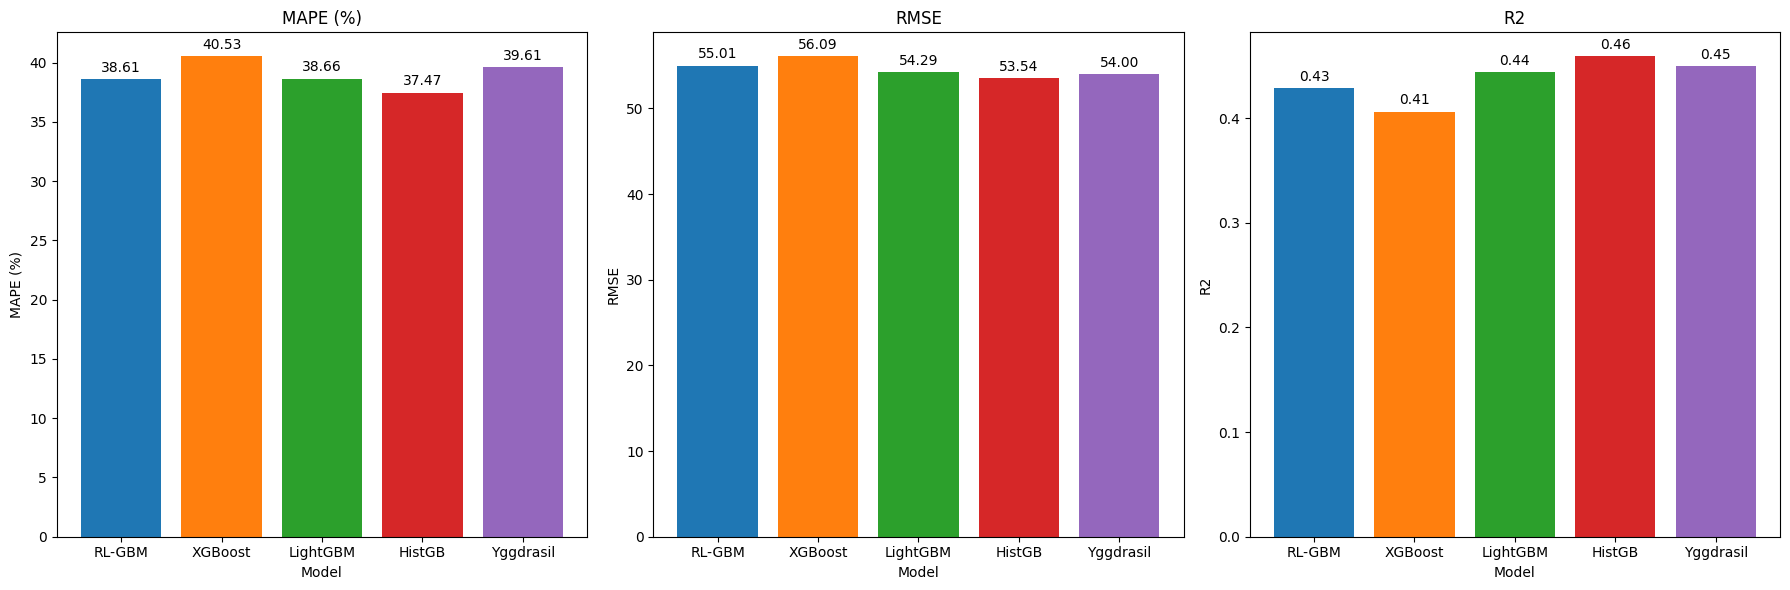

In [15]:
# Define a list of colors for each model
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Plot separate subplots for each metric
def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.annotate(
                f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom'
            )

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot MAPE
rects1 = axes[0].bar(models_list, metrics_df['MAPE (%)'], color=colors)
axes[0].set_title('MAPE (%)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAPE (%)')
autolabel(axes[0], rects1)

# Plot RMSE
rects2 = axes[1].bar(models_list, metrics_df['RMSE'], color=colors)
axes[1].set_title('RMSE')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
autolabel(axes[1], rects2)

# Plot R2
rects3 = axes[2].bar(models_list, metrics_df['R2'], color=colors)
axes[2].set_title('R2')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R2')
autolabel(axes[2], rects3)

plt.tight_layout()
plt.show()